In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/imdb-india-movies/IMDb Movies India.csv


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error,r2_score
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
import shap
import optuna
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler,StandardScaler
plt.style.use("ggplot")
import warnings
warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv('/kaggle/input/imdb-india-movies/IMDb Movies India.csv',encoding='ISO-8859-1').drop(columns='Name')
df.dropna(inplace = True)

In [4]:
df.head()

,Year,Duration,Genre,Rating,Votes,Director,Actor 1,Actor 2,Actor 3
1,(2019),109 min,Drama,7.0,8,Gaurav Bakshi,Rasika Dugal,Vivek Ghamande,Arvind Jangid
3,(2019),110 min,"Comedy, Romance",4.4,35,Ovais Khan,Prateik,Ishita Raj,Siddhant Kapoor
5,(1997),147 min,"Comedy, Drama, Musical",4.7,827,Rahul Rawail,Bobby Deol,Aishwarya Rai Bachchan,Shammi Kapoor
6,(2005),142 min,"Drama, Romance, War",7.4,"1,086",Shoojit Sircar,Jimmy Sheirgill,Minissha Lamba,Yashpal Sharma
8,(2012),82 min,"Horror, Mystery, Thriller",5.6,326,Allyson Patel,Yash Dave,Muntazir Ahmad,Kiran Bhatia


In [5]:
df.isna().sum()

Year        0
Duration    0
Genre       0
Rating      0
Votes       0
Director    0
Actor 1     0
Actor 2     0
Actor 3     0
dtype: int64

In [6]:
df.shape

(5659, 9)

In [7]:
df.duplicated().sum()

0

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5659 entries, 1 to 15508
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Year      5659 non-null   object 
 1   Duration  5659 non-null   object 
 2   Genre     5659 non-null   object 
 3   Rating    5659 non-null   float64
 4   Votes     5659 non-null   object 
 5   Director  5659 non-null   object 
 6   Actor 1   5659 non-null   object 
 7   Actor 2   5659 non-null   object 
 8   Actor 3   5659 non-null   object 
dtypes: float64(1), object(8)
memory usage: 442.1+ KB


In [9]:
df.nunique()

Year          91
Duration     174
Genre        376
Rating        83
Votes       2027
Director    2431
Actor 1     1960
Actor 2     2321
Actor 3     2556
dtype: int64

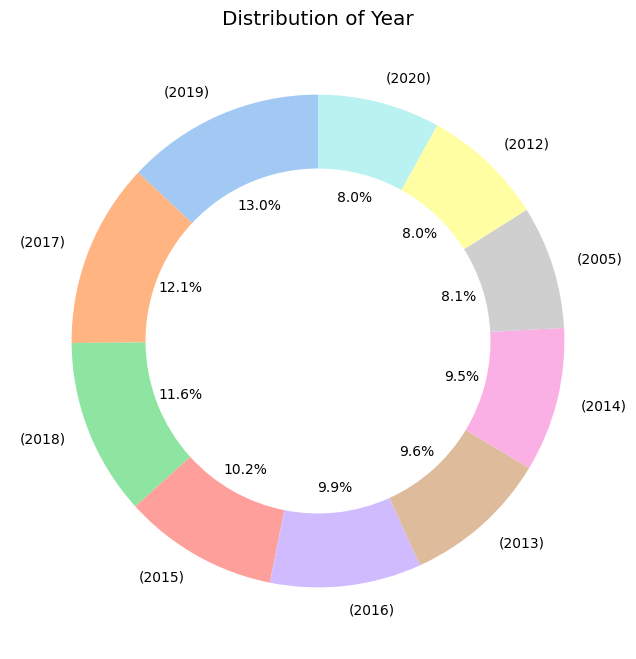

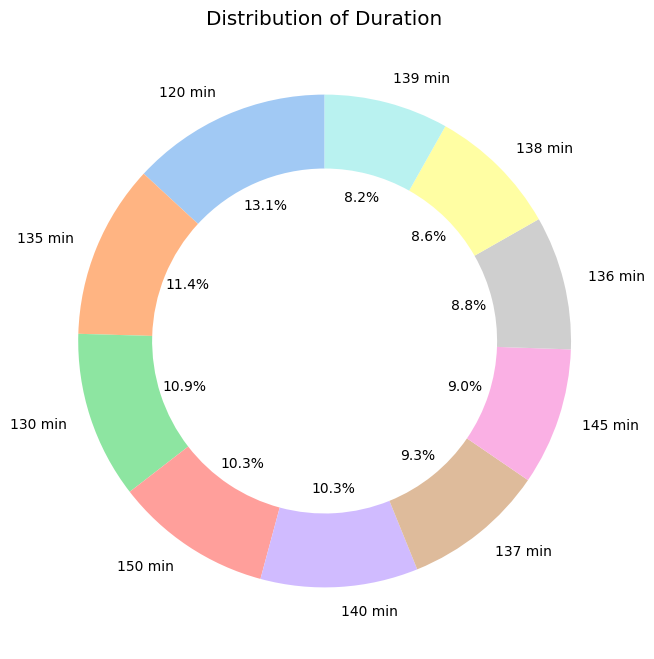

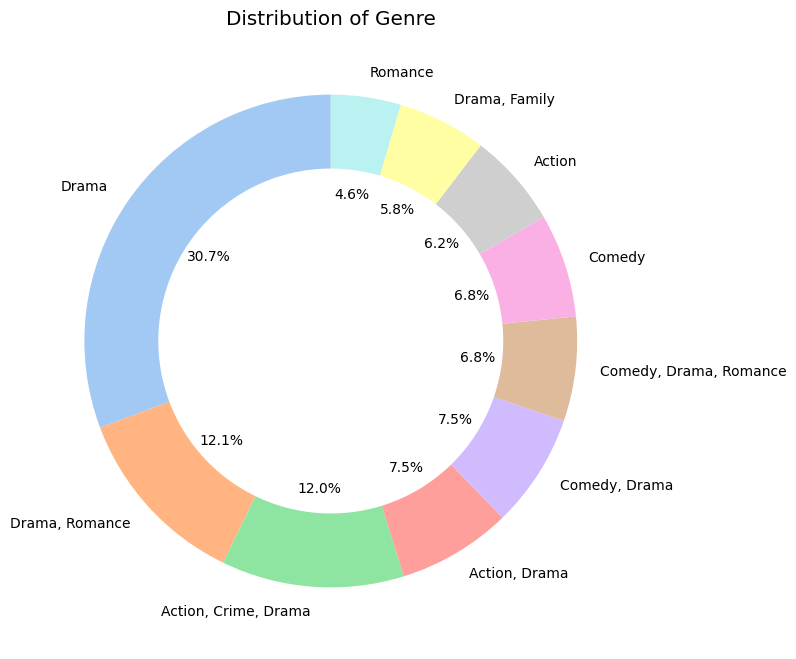

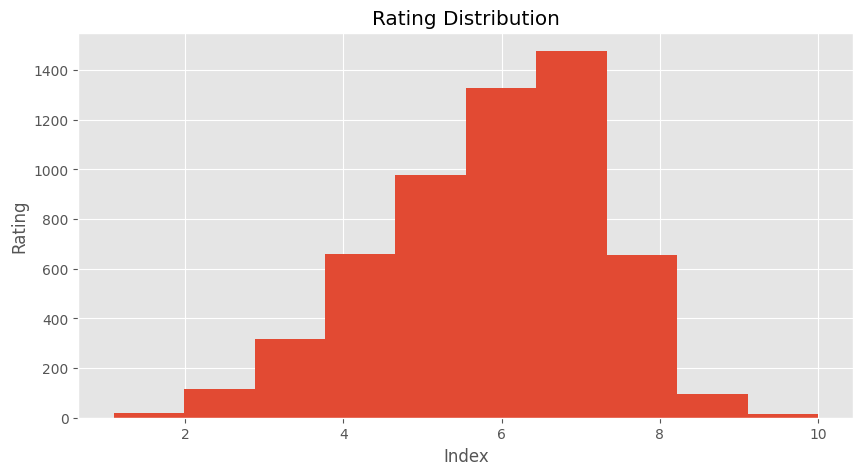

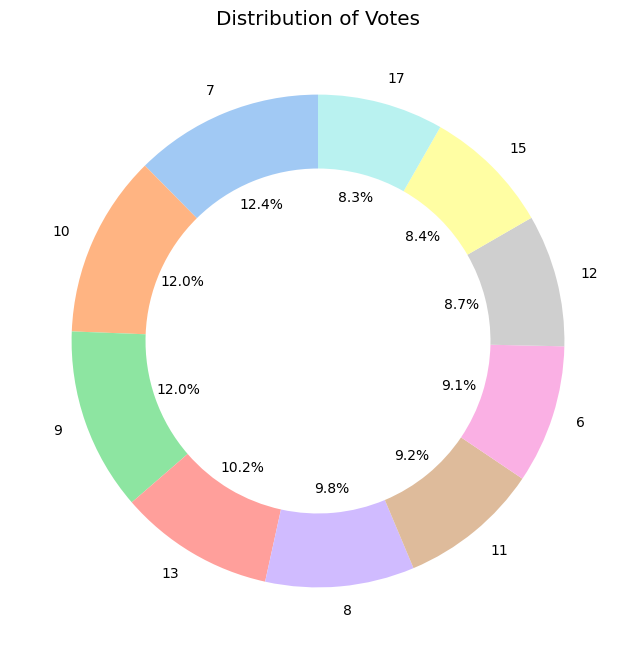

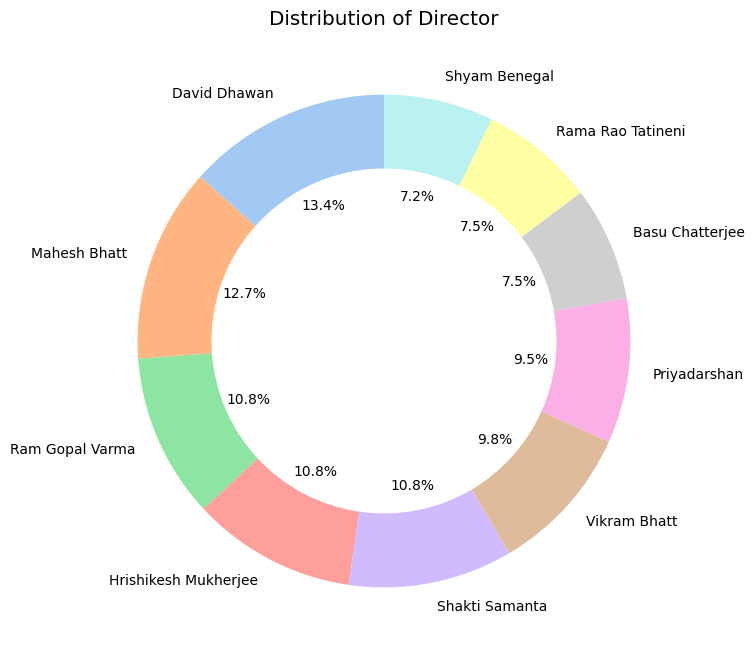

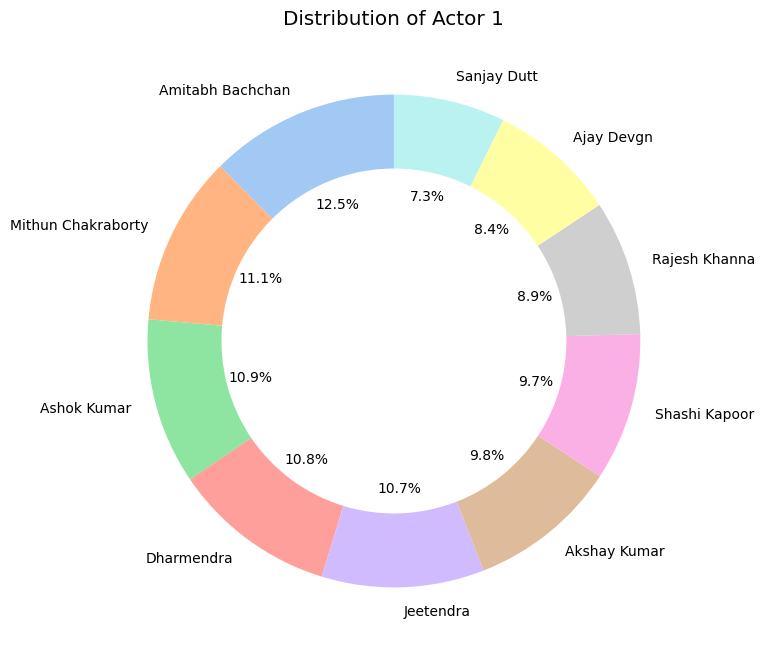

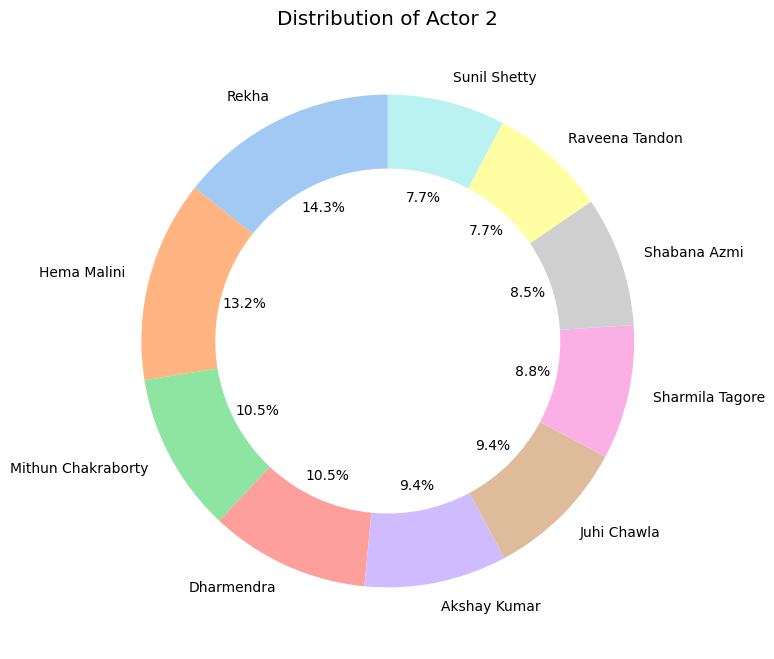

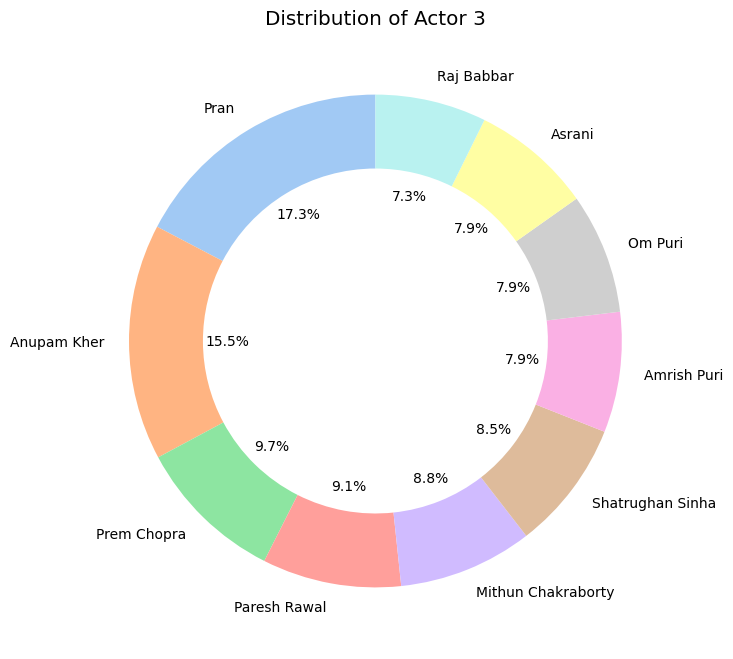

In [10]:
def plot_pie_chart(column):
    plt.figure(figsize=(8, 8))
    df[column].value_counts().head(10).plot.pie(autopct='%1.1f%%', startangle=90, colors=sns.color_palette('pastel'), wedgeprops=dict(width=0.3))
    plt.title(f'Distribution of {column}')
    plt.ylabel('')
    plt.show()
    
    
def plot_hist_chart(column):
    plt.figure(figsize=(10, 5))
    df[column].hist()
    plt.title(f'{column} Distribution')
    plt.xlabel('Index')
    plt.ylabel(column)
    plt.show()

for col in df.columns:
    if df[col].dtype == 'object':
        plot_pie_chart(col)
    else:
        plot_hist_chart(col)

In [11]:
 
df['Year'] = df['Year'].str.replace('(','')
df['Year'] = df['Year'].str.replace(')','').astype(int)

df['Duration'] = df['Duration'].str.split(' ',expand=True)[0].astype(float)

df['Votes'] = df['Votes'].str.replace(',','').astype(int)

df

,Year,Duration,Genre,Rating,Votes,Director,Actor 1,Actor 2,Actor 3
1,2019,109.0,Drama,7.0,8,Gaurav Bakshi,Rasika Dugal,Vivek Ghamande,Arvind Jangid
3,2019,110.0,"Comedy, Romance",4.4,35,Ovais Khan,Prateik,Ishita Raj,Siddhant Kapoor
5,1997,147.0,"Comedy, Drama, Musical",4.7,827,Rahul Rawail,Bobby Deol,Aishwarya Rai Bachchan,Shammi Kapoor
6,2005,142.0,"Drama, Romance, War",7.4,1086,Shoojit Sircar,Jimmy Sheirgill,Minissha Lamba,Yashpal Sharma
8,2012,82.0,"Horror, Mystery, Thriller",5.6,326,Allyson Patel,Yash Dave,Muntazir Ahmad,Kiran Bhatia
...,...,...,...,...,...,...,...,...,...
15493,2015,115.0,Drama,6.1,408,Mozez Singh,Vicky Kaushal,Sarah Jane Dias,Raaghavv Chanana
15494,2001,153.0,"Biography, Drama, History",6.2,1496,Shyam Benegal,Karisma Kapoor,Rekha,Manoj Bajpayee
15503,1989,125.0,"Action, Crime, Drama",5.8,44,S.P. Muthuraman,Chiranjeevi,Jayamalini,Rajinikanth
15505,1999,129.0,"Action, Drama",4.5,655,Kuku Kohli,Akshay Kumar,Twinkle Khanna,Aruna Irani


In [12]:
df.head()

,Year,Duration,Genre,Rating,Votes,Director,Actor 1,Actor 2,Actor 3
1,2019,109.0,Drama,7.0,8,Gaurav Bakshi,Rasika Dugal,Vivek Ghamande,Arvind Jangid
3,2019,110.0,"Comedy, Romance",4.4,35,Ovais Khan,Prateik,Ishita Raj,Siddhant Kapoor
5,1997,147.0,"Comedy, Drama, Musical",4.7,827,Rahul Rawail,Bobby Deol,Aishwarya Rai Bachchan,Shammi Kapoor
6,2005,142.0,"Drama, Romance, War",7.4,1086,Shoojit Sircar,Jimmy Sheirgill,Minissha Lamba,Yashpal Sharma
8,2012,82.0,"Horror, Mystery, Thriller",5.6,326,Allyson Patel,Yash Dave,Muntazir Ahmad,Kiran Bhatia
